Steps for building the model
- Importing and understanding data
- Preparing data
  - imputation if any
  - dummy variables
  - split data into test and train sets
  - rescaling
- Building model
  - start with recursive feature elimination (RFE)
  - build model using statsmodel with RFE features
  - optimize model (drop features if insignificant)
- Residual analysis
- Prediction on the test set
- Evaluate Model

In [1]:
# import libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')


In [2]:
# read data
df = pd.read_csv('./day.csv')

In [3]:
# skim through data set
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,27-12-2019,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


In [4]:
df.shape

(730, 16)

In [5]:
# how are the days with max and min sales
df.sort_values(by='cnt',ascending=False)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
622,623,15-09-2019,3,1,9,0,6,0,1,24.941653,29.29335,50.1667,16.583907,3160,5554,8714
636,637,29-09-2019,4,1,9,0,6,0,1,22.242500,26.51480,54.2917,15.249468,2589,5966,8555
629,630,22-09-2019,3,1,9,0,6,0,1,26.650000,30.52440,64.6667,19.000061,2512,5883,8395
446,447,23-03-2019,2,1,3,0,5,1,2,24.668347,28.50335,69.4167,7.792100,2469,5893,8362
503,504,19-05-2019,2,1,5,0,6,0,1,24.600000,28.34540,45.6250,5.626325,3410,4884,8294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,06-03-2018,1,0,3,0,0,0,2,15.437402,18.31260,94.8261,23.000229,114,491,605
25,26,26-01-2018,1,0,1,0,3,1,3,8.917500,10.18000,86.2500,19.687950,34,472,506
724,725,26-12-2019,1,1,12,0,3,1,3,9.976653,11.01665,82.3333,21.208582,9,432,441
26,27,27-01-2018,1,0,1,0,4,1,1,7.995000,10.98500,68.7500,7.627079,15,416,431


Naturally, looks like non working days with clear weather conditions have had the best sales,
and working days with non-clear weather conditions have had the least sales.

Season wise - summer and fall had high sales, winter and spring had low.

In [6]:
# visualize numeric data
# extracting numerical variables
numeric_variables = df[['temp','atemp','hum','windspeed','casual','registered','cnt']]
numeric_variables.head()


,temp,atemp,hum,windspeed,casual,registered,cnt
0,14.110847,18.18125,80.5833,10.749882,331,654,985
1,14.902598,17.68695,69.6087,16.652113,131,670,801
2,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,9.305237,11.46350,43.6957,12.522300,82,1518,1600


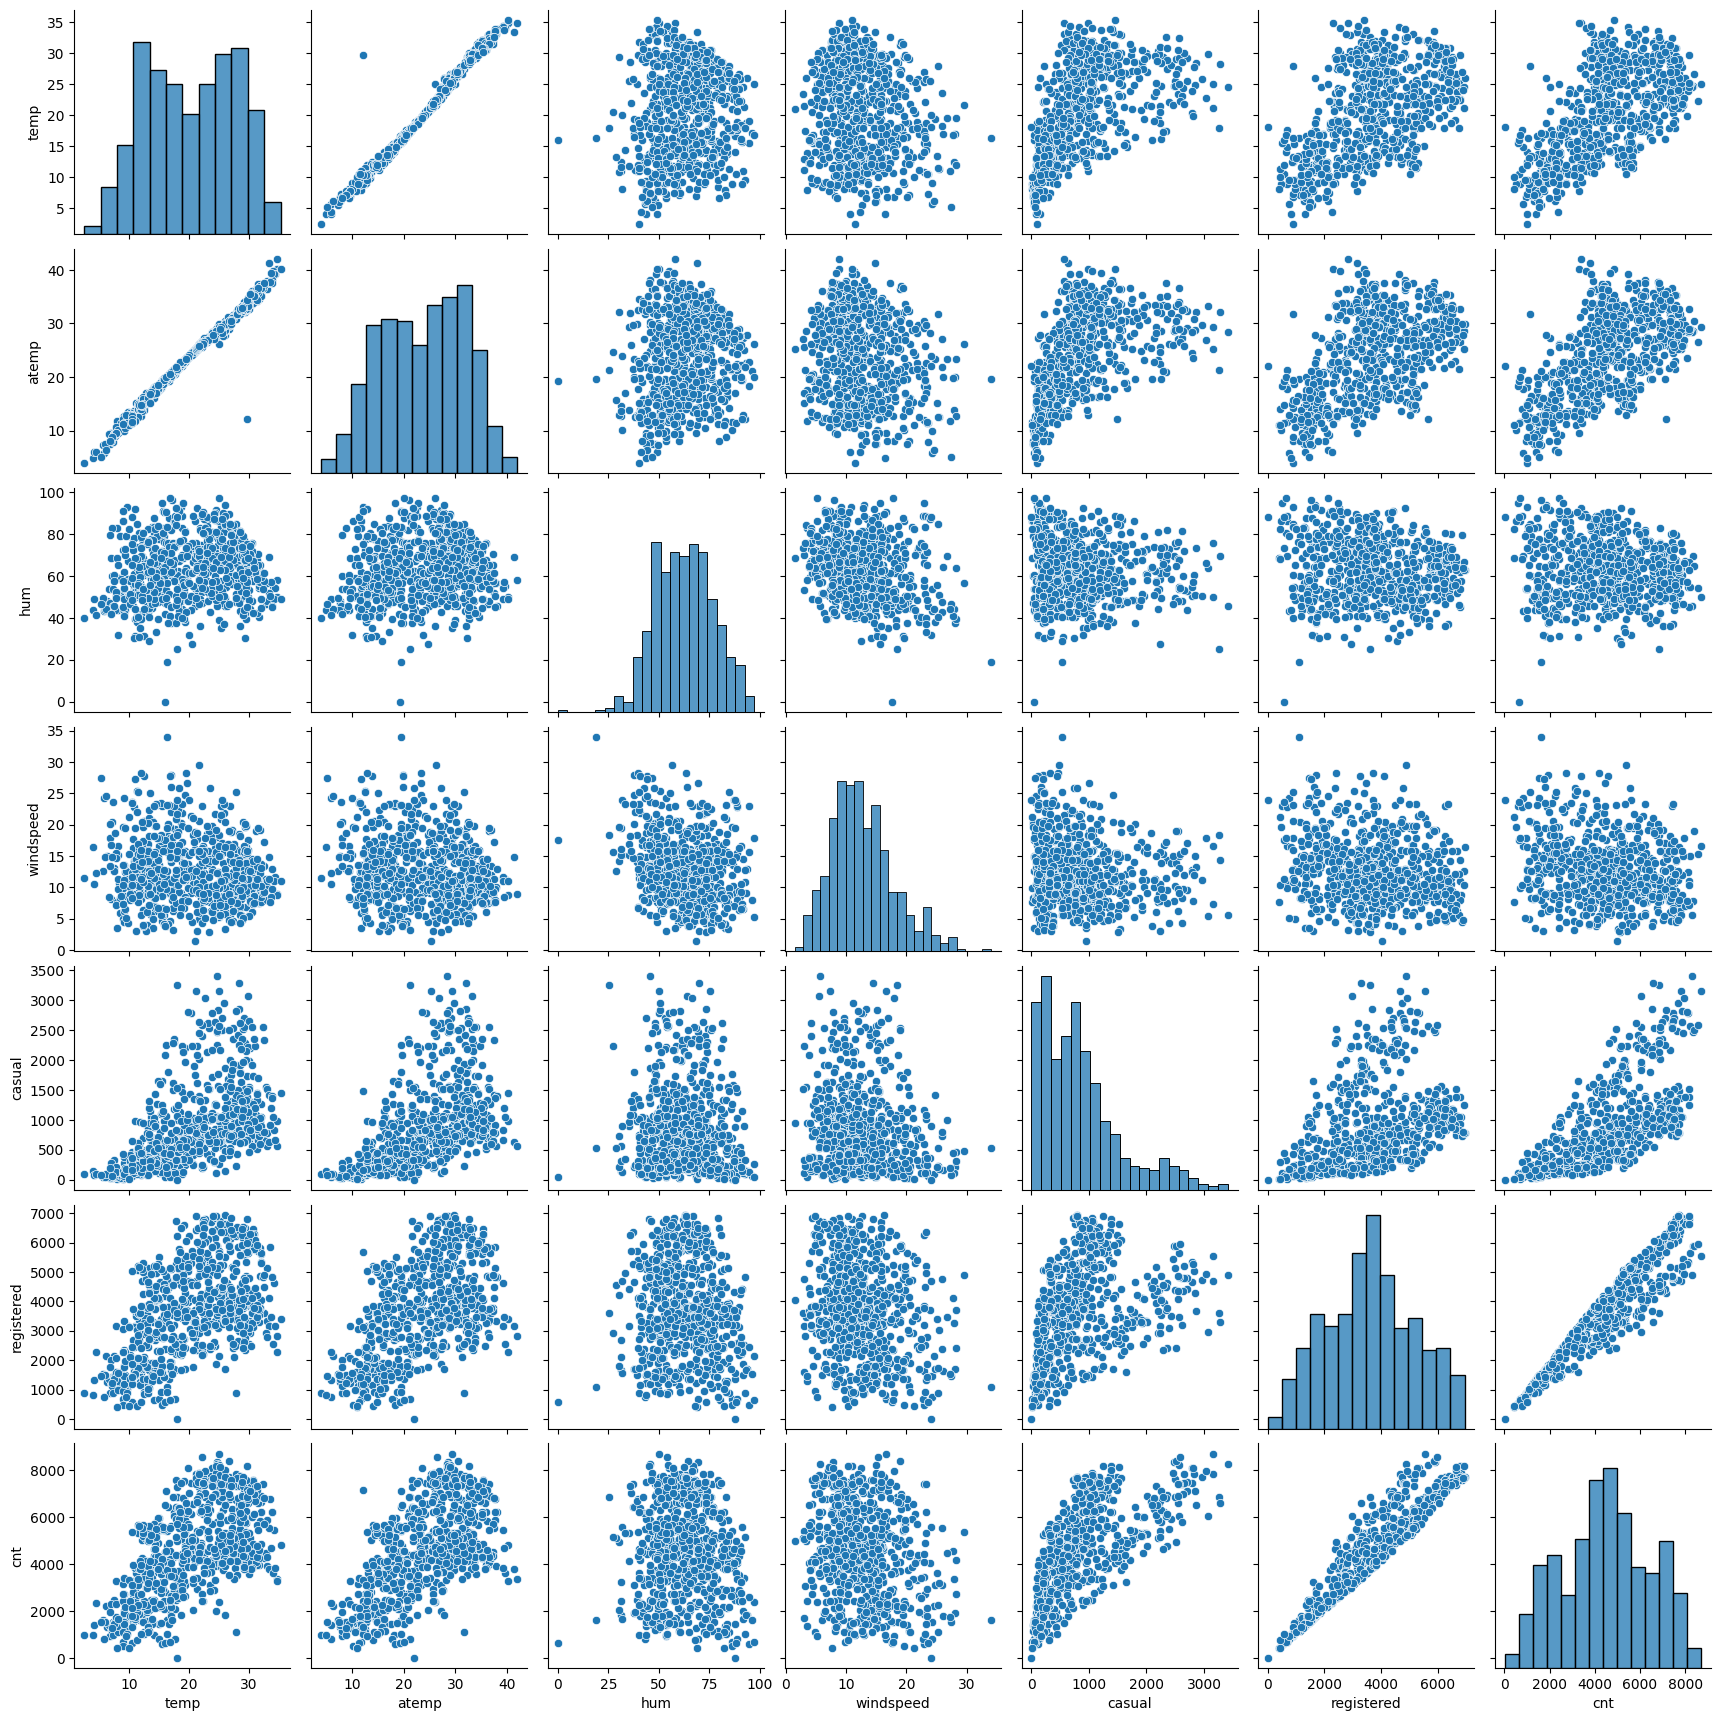

In [7]:
sns.pairplot(data=numeric_variables)

temp seems to have some linear relation with cnt and registration numbers

hum, windspeed not so much


In [8]:
# visualize categorical data
# extracting categorical data and cnt
categorical_variables =  df[['season',	'yr',	'mnth',	'holiday',	'weekday',	'workingday',	'weathersit','cnt']]
categorical_variables.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,cnt
0,1,0,1,0,6,0,2,985
1,1,0,1,0,0,0,2,801
2,1,0,1,0,1,1,1,1349
3,1,0,1,0,2,1,1,1562
4,1,0,1,0,3,1,1,1600


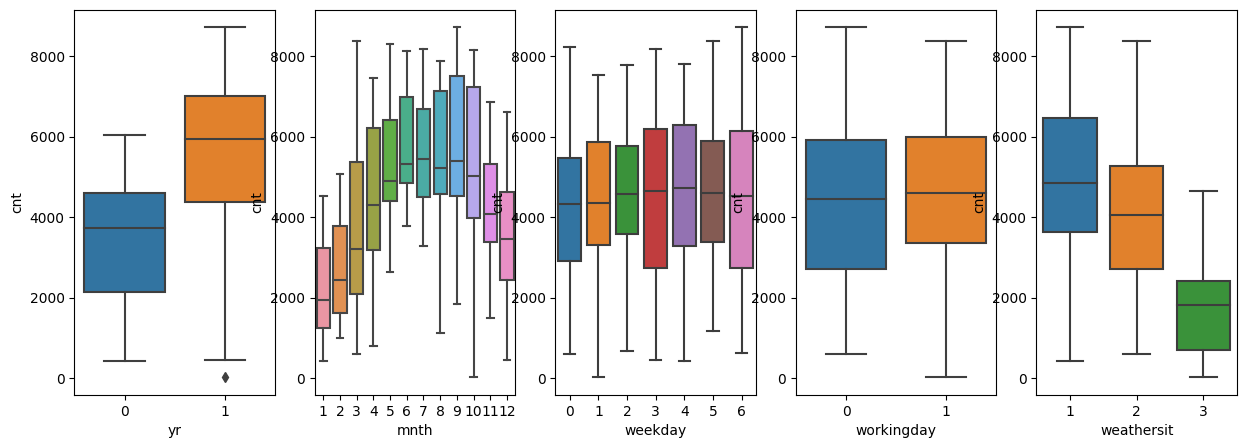

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1,5,1)
sns.boxplot(x = 'yr', y = 'cnt', data = categorical_variables)
plt.subplot(1,5,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = categorical_variables)
plt.subplot(1,5,3)
sns.boxplot(x = 'weekday', y = 'cnt', data = categorical_variables)
plt.subplot(1,5,4)
sns.boxplot(x = 'workingday', y = 'cnt', data = categorical_variables)
plt.subplot(1,5,5)
sns.boxplot(x = 'weathersit', y = 'cnt', data = categorical_variables)
plt.show()

month and weather seem to have a strong correlation with cnt.
2019 had more sales than 2018

### Data preparation

In [10]:
# check season column
df.season.value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

In [11]:
# handle 'season' column
# replace numbers with column names
# 1:spring, 2:summer, 3:fall, 4:winter
def getSeasonName(argument):
    switcher = {
        1: "spring",
        2: "summer",
        3: "fall",
        4: "winter"
    }
    return switcher.get(argument)

In [12]:
# replace numbers with strings in df
df.season = df.season.apply(lambda x: getSeasonName(x))
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,27-12-2019,spring,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,spring,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,spring,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,spring,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


In [13]:
# create dummy variables for season (n-1 columns)
seasons = pd.get_dummies(df.season, drop_first = True)

In [14]:
# verify data
seasons.value_counts()

spring  summer  winter
0       0       0         188
        1       0         184
1       0       0         180
0       0       1         178
dtype: int64

In [15]:
# validate with original data
df.season.value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [16]:
# add new columns to original data frame
df = pd.concat([df, seasons], axis = 1)

In [17]:
# check new columns
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,spring,summer,winter
0,1,01-01-2018,spring,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985,1,0,0
1,2,02-01-2018,spring,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801,1,0,0
2,3,03-01-2018,spring,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,1,0,0
3,4,04-01-2018,spring,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,1,0,0
4,5,05-01-2018,spring,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,1,0,0


In [18]:
# handle 'month' column
# replace numbers with column names
def getMonthName(argument):
    switcher = {
        1: "January",
        2: "February",
        3: "March",
        4: "April",
        5: "May",
        6: "June",
        7: "July",
        8: "August",
        9: "September",
        10: "October",
        11: "November",
        12: "December"
    }
    return switcher.get(argument)

In [19]:
# replace numbers with strings in df
df.mnth = df.mnth.apply(lambda x: getMonthName(x))

In [20]:
# create dummy variables for month (n-1 columns)
months = pd.get_dummies(df.mnth, drop_first = True)

In [21]:
# verify data
months.value_counts()

August  December  February  January  July  June  March  May  November  October  September
0       0         0         0        0     0     0      0    0         1        0            62
                                                        1    0         0        0            62
                                                 1      0    0         0        0            62
                                     1     0     0      0    0         0        0            62
                            1        0     0     0      0    0         0        0            62
        1         0         0        0     0     0      0    0         0        0            62
1       0         0         0        0     0     0      0    0         0        0            62
0       0         0         0        0     0     0      0    0         0        0            60
                                                                                1            60
                                              

In [22]:
# validate with original data
df.mnth.value_counts()

January      62
March        62
May          62
July         62
August       62
October      62
December     62
April        60
June         60
September    60
November     60
February     56
Name: mnth, dtype: int64

In [23]:
# add new columns to original data frame
df = pd.concat([df, months], axis = 1)

In [24]:
# check new columns
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,December,February,January,July,June,March,May,November,October,September
0,1,01-01-2018,spring,0,January,0,6,0,2,14.110847,...,0,0,1,0,0,0,0,0,0,0
1,2,02-01-2018,spring,0,January,0,0,0,2,14.902598,...,0,0,1,0,0,0,0,0,0,0
2,3,03-01-2018,spring,0,January,0,1,1,1,8.050924,...,0,0,1,0,0,0,0,0,0,0
3,4,04-01-2018,spring,0,January,0,2,1,1,8.200000,...,0,0,1,0,0,0,0,0,0,0
4,5,05-01-2018,spring,0,January,0,3,1,1,9.305237,...,0,0,1,0,0,0,0,0,0,0


In [25]:
# checking weekday
df.weekday.value_counts()

6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: weekday, dtype: int64

weekdays are starting at 0

In [26]:
# handle 'weekday' column
# replace numbers with column names
def getWeekDayName(argument):
    switcher = {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday"
    }
    return switcher.get(argument)

In [27]:
# replace numbers with strings in df
df.weekday = df.weekday.apply(lambda x: getWeekDayName(x))

In [28]:
# create dummy variables for month (n-1 columns)
weekdays = pd.get_dummies(df.weekday, drop_first = True)

In [29]:
# verify data
weekdays.value_counts()

Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
0       0         0       0         1        0            105
                  1       0         0        0            105
1       0         0       0         0        0            105
0       0         0       0         0        0            104
                                             1            104
        1         0       0         0        0            104
        0         0       1         0        0            103
dtype: int64

In [30]:
# validate with original data
df.weekday.value_counts()

Sunday       105
Monday       105
Tuesday      105
Wednesday    104
Friday       104
Saturday     104
Thursday     103
Name: weekday, dtype: int64

In [31]:
# add new columns to original data frame
df = pd.concat([df, weekdays], axis = 1)

In [32]:
# check new columns
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,May,November,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,01-01-2018,spring,0,January,0,Sunday,0,2,14.110847,...,0,0,0,0,0,0,1,0,0,0
1,2,02-01-2018,spring,0,January,0,Monday,0,2,14.902598,...,0,0,0,0,1,0,0,0,0,0
2,3,03-01-2018,spring,0,January,0,Tuesday,1,1,8.050924,...,0,0,0,0,0,0,0,0,1,0
3,4,04-01-2018,spring,0,January,0,Wednesday,1,1,8.200000,...,0,0,0,0,0,0,0,0,0,1
4,5,05-01-2018,spring,0,January,0,Thursday,1,1,9.305237,...,0,0,0,0,0,0,0,1,0,0


In [33]:
# handle 'weathersit' column
# replace numbers with column names

# - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

        
def getWeatherName(argument):
    switcher = {
        1: "Clear",
        2: "Mist",
        3: "Light snow",
        4: "Heavy rain",
    }
    return switcher.get(argument)

In [34]:
# replace numbers with strings in df
df.weathersit = df.weathersit.apply(lambda x: getWeatherName(x))

In [35]:
# create dummy variables for month (n-1 columns)
weatherNames = pd.get_dummies(df.weathersit, drop_first = True)

In [36]:
# verify data
weatherNames.value_counts()

Light snow  Mist
0           0       463
            1       246
1           0        21
dtype: int64

In [37]:
# validate with original data
df.weathersit.value_counts()

Clear         463
Mist          246
Light snow     21
Name: weathersit, dtype: int64

In [38]:
# add new columns to original data frame
df = pd.concat([df, weatherNames], axis = 1)

In [39]:
# check new columns
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light snow,Mist
0,1,01-01-2018,spring,0,January,0,Sunday,0,Mist,14.110847,...,0,0,0,0,1,0,0,0,0,1
1,2,02-01-2018,spring,0,January,0,Monday,0,Mist,14.902598,...,0,0,1,0,0,0,0,0,0,1
2,3,03-01-2018,spring,0,January,0,Tuesday,1,Clear,8.050924,...,0,0,0,0,0,0,1,0,0,0
3,4,04-01-2018,spring,0,January,0,Wednesday,1,Clear,8.200000,...,0,0,0,0,0,0,0,1,0,0
4,5,05-01-2018,spring,0,January,0,Thursday,1,Clear,9.305237,...,0,0,0,0,0,1,0,0,0,0


In [40]:
# dropping unwanted and converted columns
df.drop(['instant'], axis = 1, inplace = True)
df.drop(['dteday'], axis = 1, inplace = True)
df.drop(['season'], axis = 1, inplace = True)
df.drop(['mnth'], axis = 1, inplace = True)
df.drop(['weekday'], axis = 1, inplace = True)
df.drop(['weathersit'], axis = 1, inplace = True)
df.drop(['casual'], axis = 1, inplace = True)
df.drop(['registered'], axis = 1, inplace = True)
df

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light snow,Mist
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,0,1,10.420847,11.33210,65.2917,23.458911,2114,1,0,...,0,0,0,0,0,0,0,0,0,1
726,1,0,1,10.386653,12.75230,59.0000,10.416557,3095,1,0,...,0,0,0,1,0,0,0,0,0,1
727,1,0,0,10.386653,12.12000,75.2917,8.333661,1341,1,0,...,0,0,0,0,1,0,0,0,0,1
728,1,0,0,10.489153,11.58500,48.3333,23.500518,1796,1,0,...,0,0,1,0,0,0,0,0,0,0


### Model building

In [41]:
# splitting data into test and train sets
np.random.seed(0)
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [42]:
# data scaling
# choose scaler
scaler = MinMaxScaler()

In [43]:
# apply scaler to numeric variables
numeric_columns = [ 'temp', 'atemp', 'hum', 'windspeed','cnt']
df_train[numeric_columns] = scaler.fit_transform(df_train[numeric_columns])

In [44]:
# verify train df after scaling
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light snow,Mist
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,...,1,0,0,0,0,0,0,1,0,0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,0,0,0,0,1,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,0,1,0,0,0,0,1
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,0,0,1,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,0,1,0,0,0,0,1


In [45]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light snow,Mist
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537262,0.512989,0.650369,0.320768,0.513620,0.243137,0.245098,...,0.086275,0.080392,0.143137,0.127451,0.154902,0.158824,0.150980,0.131373,0.029412,0.343137
std,0.500429,0.157763,0.468282,0.225844,0.212385,0.145882,0.169797,0.224593,0.429398,0.430568,...,0.281045,0.272166,0.350557,0.333805,0.362166,0.365870,0.358381,0.338139,0.169124,0.475223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.540519,0.526811,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


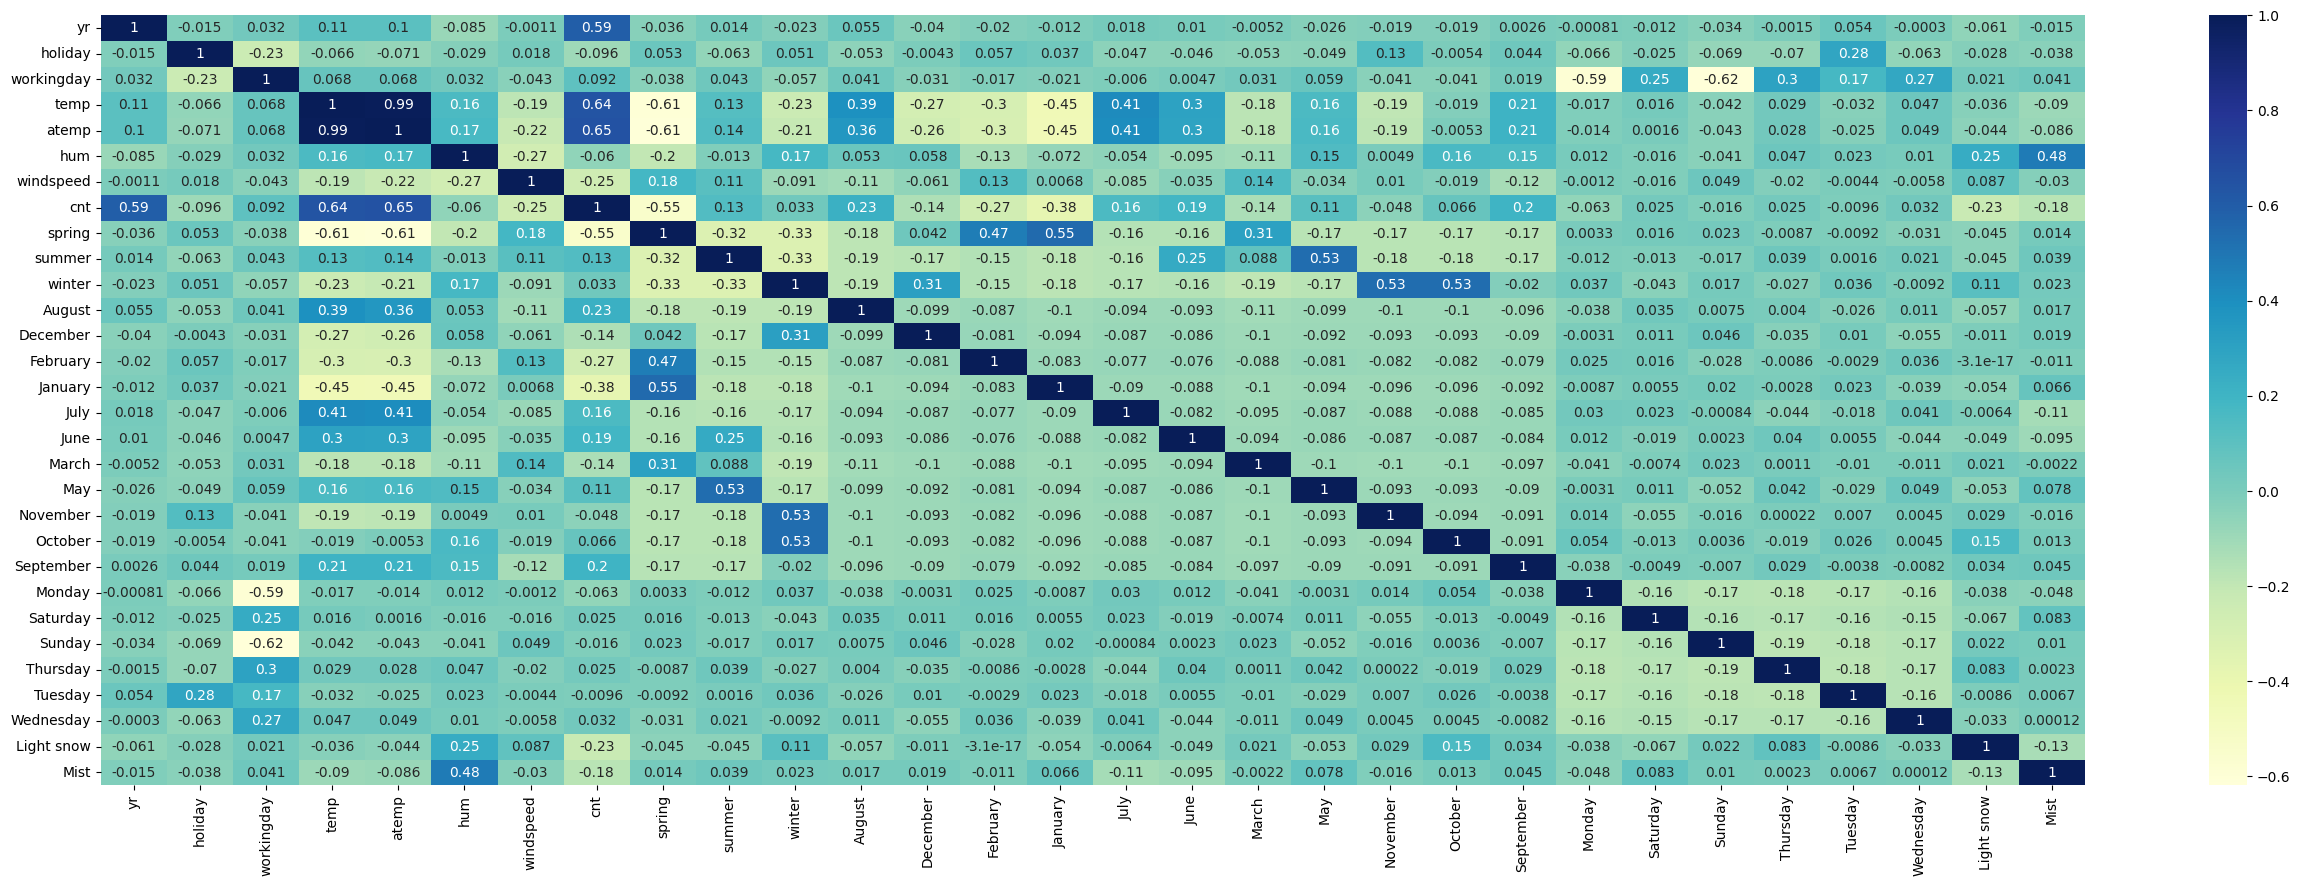

In [46]:
# visualizing correlations
plt.figure(figsize = (32, 10))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

### Model building

In [47]:
# choosing x and y sets for model building
y_train = df_train.pop('cnt')
X_train = df_train

In [48]:
# Running Recursive Feature Elimination (RFE)
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=11, step=1)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [49]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 11),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', False, 10),
 ('summer', False, 2),
 ('winter', True, 1),
 ('August', False, 4),
 ('December', False, 6),
 ('February', False, 8),
 ('January', False, 5),
 ('July', False, 17),
 ('June', False, 18),
 ('March', False, 19),
 ('May', False, 9),
 ('November', False, 7),
 ('October', False, 12),
 ('September', True, 1),
 ('Monday', True, 1),
 ('Saturday', False, 15),
 ('Sunday', True, 1),
 ('Thursday', False, 16),
 ('Tuesday', False, 13),
 ('Wednesday', False, 14),
 ('Light snow', True, 1),
 ('Mist', False, 3)]

In [50]:
# eliminated columns
eliminated_columns = X_train.columns[~rfe.support_]
eliminated_columns

Index(['atemp', 'spring', 'summer', 'August', 'December', 'February',
       'January', 'July', 'June', 'March', 'May', 'November', 'October',
       'Saturday', 'Thursday', 'Tuesday', 'Wednesday', 'Mist'],
      dtype='object')

Building model with statsmodel, for getting detailed statistics

In [51]:
# choosing columns for model building
col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]

In [52]:
# add constant variable to statsmodel object for intercept
X_train_rfe = sm.add_constant(X_train_rfe)

In [53]:
# running a linear model
lm = sm.OLS(y_train,X_train_rfe).fit()

In [54]:
# print model results
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     213.2
Date:                Tue, 10 Jan 2023   Prob (F-statistic):          5.05e-173
Time:                        07:10:19   Log-Likelihood:                 462.48
No. Observations:                 510   AIC:                            -903.0
Df Residuals:                     499   BIC:                            -856.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1895      0.023      8.367      0.0

In [55]:
# calculate variance inflation factor for the model
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,holiday,inf
3,workingday,inf
9,Monday,inf
10,Sunday,inf
5,hum,1.24
4,temp,1.20
6,windspeed,1.15
7,winter,1.13
11,Light snow,1.11
8,September,1.07


### thumb rule for dropping a variable
High p, High VIF --> drop

High p, Low VIF --> drop first

Low p, High VIF --> drop these after the ones above

Low p, Low VIF --> keep them

thresholds 

p value should be less than 0.05
VIF should be less than 5


In [56]:
# dropping atemp 
# X_train_rfe = X_train_rfe.drop('atemp', 1)

In [57]:
# rebuild model
X_train_rfe = sm.add_constant(X_train_rfe)

lm = sm.OLS(y_train, X_train_rfe).fit()

In [58]:
# see results
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     213.2
Date:                Tue, 10 Jan 2023   Prob (F-statistic):          5.05e-173
Time:                        07:10:20   Log-Likelihood:                 462.48
No. Observations:                 510   AIC:                            -903.0
Df Residuals:                     499   BIC:                            -856.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1895      0.023      8.367      0.0

In [59]:
# Calculate the VIFs again for the new model

vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,holiday,inf
3,workingday,inf
9,Monday,inf
10,Sunday,inf
5,hum,1.24
4,temp,1.20
6,windspeed,1.15
7,winter,1.13
11,Light snow,1.11
8,September,1.07


### Residual analysis


In [60]:
# calculate y values from the model
y_train_pred = lm.predict(X_train_rfe)

Text(0.5, 0, 'Errors')

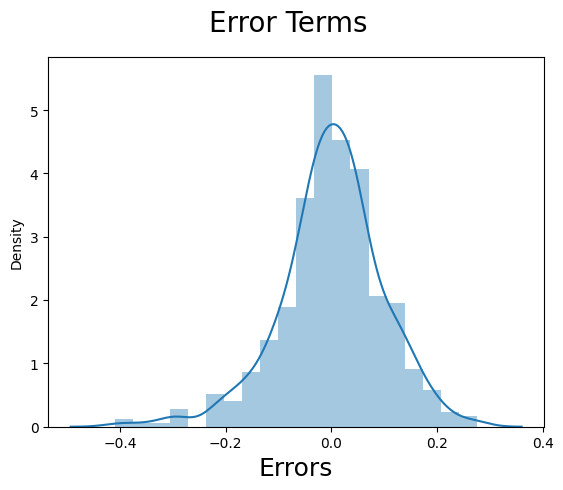

In [61]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)   

### Making predictions on the final model

In [62]:
# apply scaling on the test data set
# apply scaler to numeric variables
numeric_columns = [ 'temp', 'atemp', 'hum', 'windspeed','cnt']
df_test[numeric_columns] = scaler.transform(df_test[numeric_columns])

In [63]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,October,September,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light snow,Mist
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.479452,0.036530,0.698630,0.558941,0.532991,0.638508,0.313350,0.520592,0.255708,0.264840,...,0.082192,0.086758,0.146119,0.178082,0.118721,0.100457,0.127854,0.164384,0.027397,0.319635
std,0.500722,0.188034,0.459904,0.233698,0.217888,0.148974,0.159947,0.218435,0.437258,0.442259,...,0.275286,0.282125,0.354034,0.383458,0.324202,0.301297,0.334692,0.371472,0.163612,0.467403
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.354650,0.344751,0.527265,0.198517,0.377531,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558691,0.549198,0.627737,0.299459,0.524275,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.759096,0.714132,0.743928,0.403048,0.672745,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [64]:
# divide into X_test and y_test
y_test = df_test.pop('cnt')
X_test = df_test

In [65]:
# adding constant variable to test dataframe
X_test = sm.add_constant(X_test)

In [66]:
# dropping the columns that were eliminated in model building
X_test = X_test.drop(eliminated_columns, axis = 1)

In [67]:
# make predictions on the new model
y_test_pred = lm.predict(X_test)

In [68]:
r2_score(y_test, y_test_pred)

0.7807714182114645

Text(0, 0.5, 'y_pred')

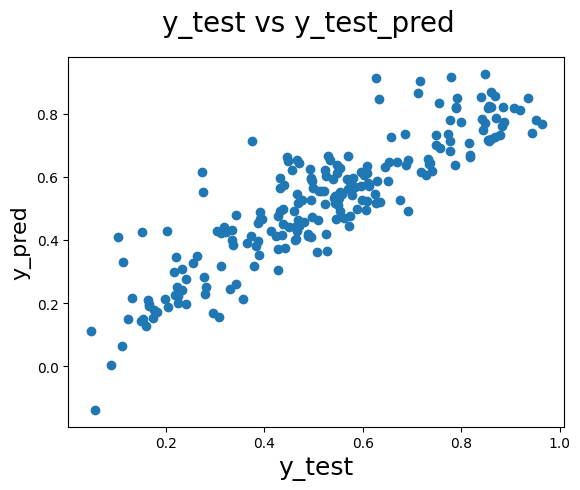

In [69]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      